In [1]:
import sys
sys.path.append("../..")

# Noisy Pendulum - Parameter estimation

Estimate pendulum parameter posterior distribution with GHKF and PMCM as in example 12.2 of the book.


## Imports

### Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, stats
import tqdm

### Helpers imports

In [3]:
from python.common_utilities import generate_pendulum, RandomState, rmse, plot_pendulum

## Routine

Set the parameters:

In [5]:
dt = 0.01
g  = 9.81

In [6]:
Q  = 0.01 * np.array([[dt ** 3 / 3, dt ** 2 / 2], 
                       [dt ** 2 / 2, dt]])
R  = 0.1

In [7]:
x_0 = np.array([1.5, 0.])

## Simulate data

In [8]:
random_state = RandomState(1)
steps = 500

timeline, states, observations = generate_pendulum(x_0, g, Q, dt, R, steps, random_state)

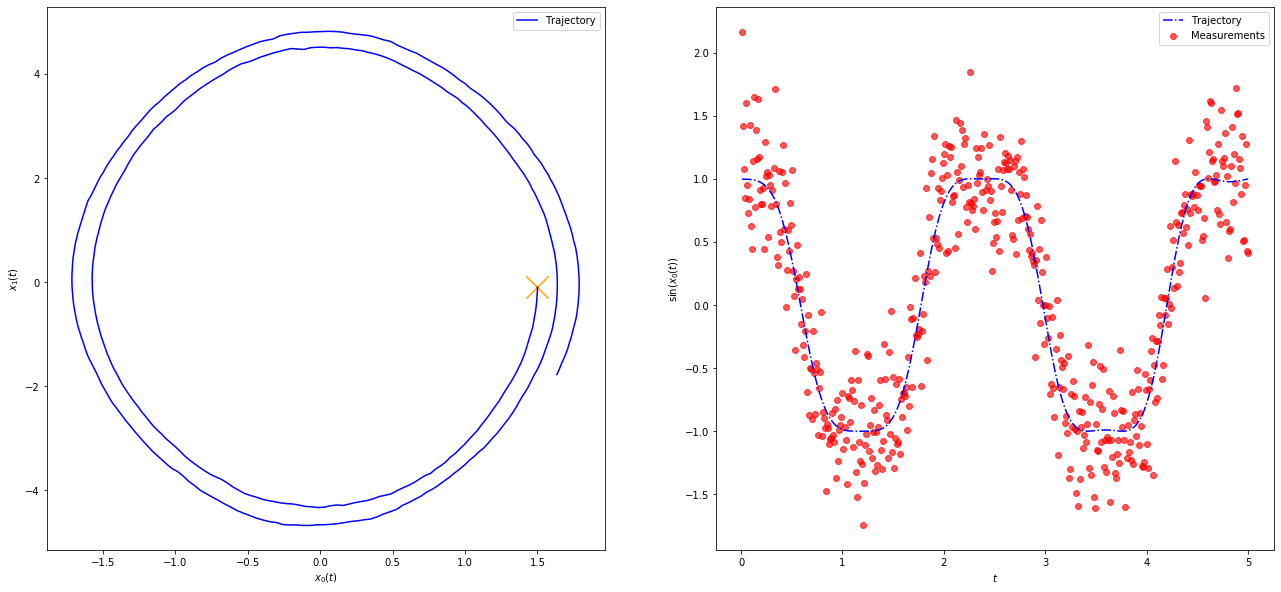

In [9]:
plot(timeline, observations, states, "Trajectory")

## GHKF

In [10]:
m_0 = np.array([1.6, 0.])  # Slightly off
P_0 = np.array([[0.1, 0.], 
                [0., 0.1]])

In [11]:
# method parameters
from itertools import product
from numpy.polynomial.hermite_e import hermegauss

order = 5
n = m_0.shape[0]

sample_points, hermite_weights = hermegauss(order)  # 1D points
hermite_weights = hermite_weights / hermite_weights.sum()

# n-D points
sample_points = np.array(list(product(*(sample_points for _ in range(n))))).T  # Cartesian product
hermite_weights = np.array(list(product(*(hermite_weights for _ in range(n))))).prod(axis=1)


In [12]:
def gh_kalman_filter(m_0, P_0, g, Q, dt, r, observations, sample_points, hermite_weights):
    M = m_0.shape[-1]
    steps = observations.shape[0]
    
    m = m_0[:]
    P = P_0[:]
    
    zeros = np.zeros((n, 1))
    log_likelihood = 0.
    
    for i in range(steps):
        observation = observations[i]
        
        # Compute the Sigma-Points for the dynamics
        L = np.linalg.cholesky(P)
        sigma_points = L @ sample_points + m.reshape(-1, 1)
        
        # Progagate through the dynamics
        sigma_points[0, :], sigma_points[1, :] = sigma_points[0, :] + dt * sigma_points[1, :], sigma_points[1, :] - g * dt * np.sin(sigma_points[0, :])        
        
        # Predicted state distribution
        m = np.dot(sigma_points, hermite_weights)
        P = np.dot(hermite_weights.reshape(1, -1) * (sigma_points - m.reshape(-1, 1)), (sigma_points - m.reshape(-1, 1)).T) + Q

        # Compute the Sigma-Points for the observation
        L = np.linalg.cholesky(P)
        sigma_points = L @ sample_points + m.reshape(-1, 1)
        
        # Progagate through the measurement model
        sigma_observations = np.sin(sigma_points[0, :])
        
        # sigma points measurement mean and covariance
        predicted_mu = np.dot(sigma_observations, hermite_weights)
        predicted_cov = np.dot(hermite_weights * (sigma_observations - predicted_mu), sigma_observations - predicted_mu) + r
        cross_cov = np.dot(sigma_points - m.reshape(-1, 1), hermite_weights * (sigma_observations - predicted_mu))
        
        # Gain
        K = cross_cov / predicted_cov
        # More efficient and stable way of computing K = P @ H.T @ linalg.inv(S)
        # This also leverages the fact that S is known to be a positive definite matrix (assume_a="pos")
        
        v = observation - predicted_mu
        m = m + K * v
        P = P - predicted_cov * K.reshape(-1, 1) * K
        log_likelihood += stats.norm.logpdf(v, loc=0., scale=predicted_cov ** 0.5)
    return log_likelihood

In [13]:
def get_posterior(dR, m_0, P_0, g, Q, dt, observations, sample_points, hermite_weights):
    linspace = np.arange(0.06, 0.15, dR)
    log_likelihoods = np.empty_like(linspace)
    for i, r in tqdm.tqdm(enumerate(linspace), total=len(linspace)):
        ll = gh_kalman_filter(m_0, P_0, g, Q, dt, r, observations, sample_points, hermite_weights)
        log_likelihoods[i] = ll
    log_likelihoods = log_likelihoods - np.max(log_likelihoods)
    energies = np.exp(log_likelihoods)
    energies = energies / energies.sum()
    return linspace, energies / dR

In [14]:
dR = 0.005
Rs, energies = get_posterior(dR, m_0, P_0, g, Q, dt, observations, sample_points, hermite_weights)

100%|██████████| 18/18 [00:01<00:00, 11.58it/s]


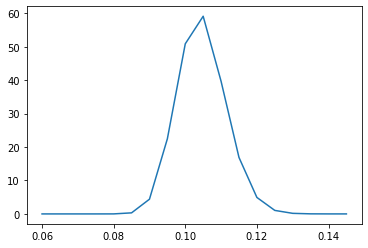

In [15]:
plt.plot(Rs, energies)

## Particle MCMC

In [17]:
def stratified_resampling(w, random_state):
    """ Generate non decreasing numbers x_i between [0, 1]
    """
    n_particles = w.shape[0]
    z = random_state.rand(n_particles) + np.linspace(0., n_particles - 1., n_particles)
    us = z / n_particles
    cs = np.cumsum(w)
    idx = np.searchsorted(cs, us, side='left')

    return np.clip(idx, 0, n_particles - 1)


In [18]:
def normalise(w):
    """Normalises the positive vector w so that it sums to 1"""
    return w / np.sum(w, axis=-1, keepdims=True)

In [19]:
def particle_filter(m_0, P_0, g, Q, dt, r, observations, n_particles, random_state):
    steps = observations.shape[0]
    chol_P0 = np.linalg.cholesky(P_0)
    chol_Q = np.linalg.cholesky(Q)
    sqrt_R = np.sqrt(r)
    state = m_0.reshape(2, 1) + np.matmul(chol_P0, random_state.randn(2, n_particles))
    log_likelihood = 0.
    
    frozen_dist = stats.norm(0., sqrt_R)
    
    for i in range(steps):
        # Propagate through the dynamic model: cross-term update
        state[0, :], state[1, :] = state[0, :] + dt * state[1, :], state[1, :] - g * dt * np.sin(state[0, :])
        
        # Add the process noise
        state = state + np.matmul(chol_Q, random_state.randn(2, n_particles))
        # Compute the unnormalized importance weights
        obs = observations[i]
        w = frozen_dist.pdf(np.sin(state[0, :])- obs)

        log_likelihood += np.log(np.mean(w))
        # Normalize them
        w = normalise(w)
        
        # Do resampling
        ind = stratified_resampling(w, random_state)
        state = state[:, ind]
        
    return log_likelihood

In [20]:
def mcmc(r_0, proposal_noise_0, target_acceptance, n_mcmc, m_0, P_0, g, Q, dt, R, observations, n_particles, random_state, do_ram=True, do_ram_from=10):
    energy = float("inf")
    samples = np.empty(n_mcmc)
    i = 0
    r = r_0
    proposal_noise = proposal_noise_0
    accepted = 0
        
    pbar = tqdm.trange(n_mcmc)
    pbar.set_description(f'MCMC(accepted=0, current_log(r)={r})')
    for i in pbar:
        new_r = r + proposal_noise * random_state.randn()
        
        minus_ll = -particle_filter(m_0, P_0, g, Q, dt, np.exp(new_r), observations, n_particles, random_state)
        acceptance_proba = min(1, np.exp(energy - minus_ll))
        u = random_state.rand()
        if u <= acceptance_proba:
            samples[i] = new_r
            r = new_r
            energy = minus_ll
            accepted += 1
            pbar.set_description(f'MCMC(accepted={accepted}, current_log(r)={r}, proposal_noise={proposal_noise}, energy={energy})')
        else:
            samples[i] = r
            
        if do_ram and (i > do_ram_from):
            nu = 1 / (i**0.9)
            proposal_noise *= np.sqrt(1 + nu * (acceptance_proba - target_acceptance))

    return samples, accepted
    
    

In [21]:
n_particles = 100
n_mcmc = 1000
proposal_noise_0 = 0.25
target_acceptance = 0.234
r_0 = -2

samples, accepted = mcmc(r_0, proposal_noise_0, target_acceptance, n_mcmc, m_0, P_0, g, Q, dt, R, observations, n_particles, random_state, do_ram=True, do_ram_from=10)

MCMC(accepted=198, current_log(r)=-2.2331808123163674, proposal_noise=0.18258608321440184, energy=146.11971602883483): 100%|██████████| 1000/1000 [02:02<00:00,  8.16it/s]


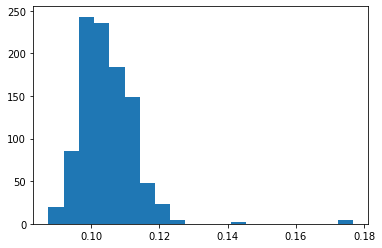

In [22]:
_ = plt.hist(np.exp(samples), bins=20)